In [21]:
!pip install mahotas

     |████████████████████████████████| 5.7MB 4.6MB/s 


In [1]:
import cv2
import joblib
import mahotas
import numpy as np
from skimage import feature
from sklearn.svm import LinearSVC
from google.colab.patches import cv2_imshow

In [2]:
def resize(image, width=None, height=None, inter=cv2.INTER_AREA):
    (h, w) = image.shape[:2]

    if width is None and height is None:
        return image

    if width is None:
        r = height / float(h)
        dim = (int(w * r), height)
    else:
        r = width / float(w)
        dim = (width, int(h * r))

    resized = cv2.resize(image, dim, interpolation=inter)

    return resized

def load_digits(dataset_path):
    data = np.genfromtxt(dataset_path, delimiter=',', dtype='uint8')
    target = data[:, 0]
    data = data[:, 1:].reshape(data.shape[0], 28, 28)

    return data, target

def deskew(image, width):
    (h, w) = image.shape[:2]
    moments = cv2.moments(image)

    skew = moments['mu11'] / moments['mu02']

    M = np.float32([[1, skew, -0.5 * w * skew],
                    [0, 1, 0]])

    image = cv2.warpAffine(image, M, (w, h), flags=cv2.WARP_INVERSE_MAP | cv2.INTER_LINEAR)
    image = resize(image, width=width)

    return image


def center_extent(image, size):
    (e_w, e_h) = size

    if image.shape[1] > image.shape[0]:
        image = resize(image, width=e_w)
    else:
        image = resize(image, height=e_h)

    extent = np.zeros((e_h, e_w), dtype='uint8')

    offset_x = (e_w - image.shape[1]) // 2
    offset_y = (e_h - image.shape[0]) // 2
    extent[offset_y:offset_y + image.shape[0], offset_x:offset_x + image.shape[1]] = image

    cm = mahotas.center_of_mass(extent)
    (c_y, c_x) = np.round(cm).astype('int32')
    (d_x, d_y) = ((size[0] // 2) - c_x, (size[1] // 2) - c_y)

    M = np.float32([[1, 0, d_x], [0, 1, d_y]])
    extent = cv2.warpAffine(extent, M, size)

    return extent

In [3]:
class HOG(object):
    def __init__(self, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(3, 3), transform=True):
        self.orientations = orientations
        self.pixels_per_cell = pixels_per_cell
        self.cells_per_block = cells_per_block
        self.transform = transform

    def describe(self, image):
        histogram = feature.hog(image, orientations=self.orientations, pixels_per_cell=self.pixels_per_cell,
                                cells_per_block=self.cells_per_block, transform_sqrt=self.transform)

        return histogram

In [4]:
(digits, target) = load_digits('digits.csv')

In [5]:
hog = HOG(orientations=18, pixels_per_cell=(10, 10), cells_per_block=(1, 1), transform=True)
data = []

for image in digits:
    image = deskew(image, 20)
    image = center_extent(image, (20, 20))

    histogram = hog.describe(image)
    data.append(histogram)

model = LinearSVC(random_state=42)
model.fit(data, target)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=42, tol=0.0001,
          verbose=0)

I think that number is: 1


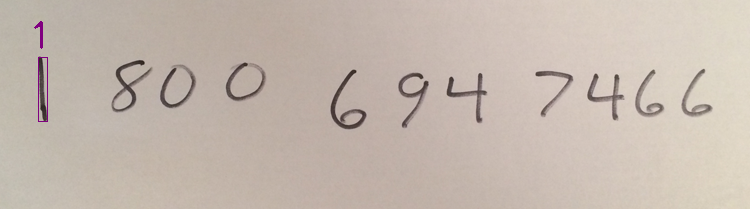

I think that number is: 8


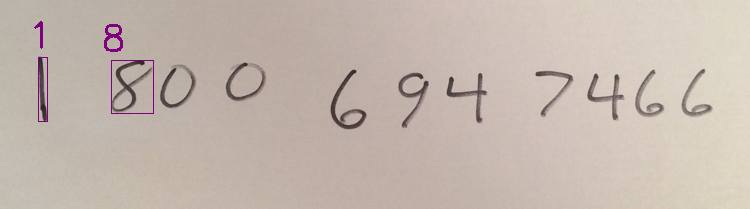

I think that number is: 0


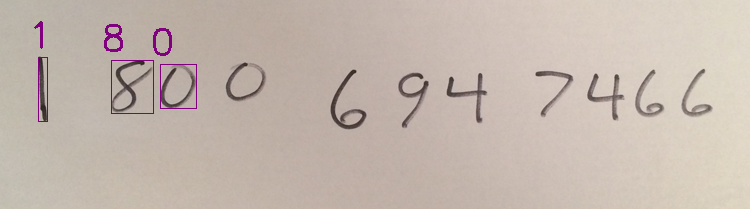

I think that number is: 6


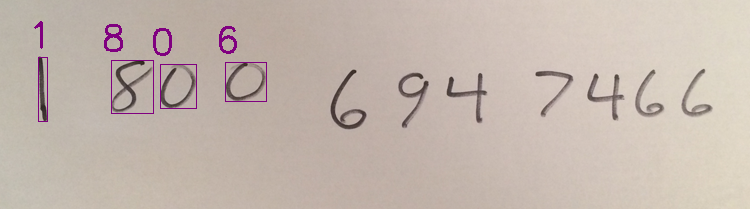

I think that number is: 6


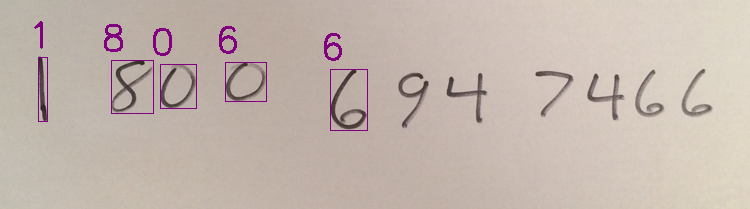

I think that number is: 9


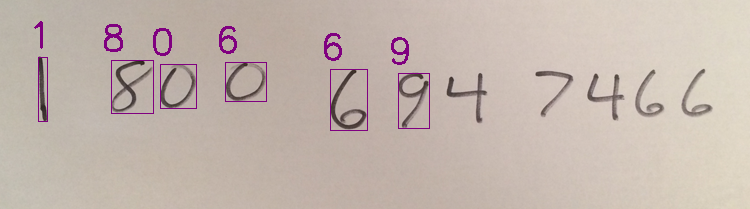

I think that number is: 4


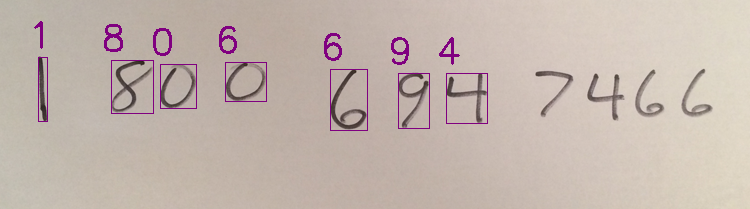

I think that number is: 7


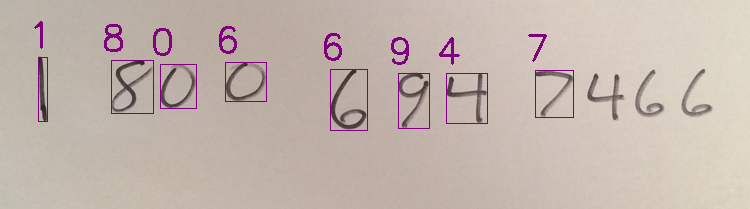

I think that number is: 4


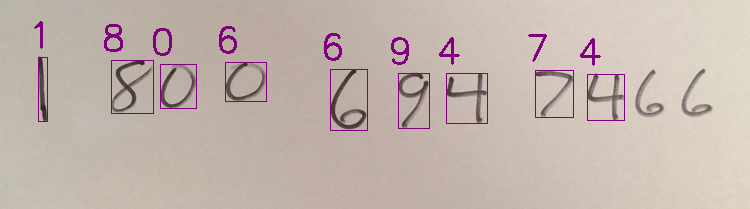

I think that number is: 6


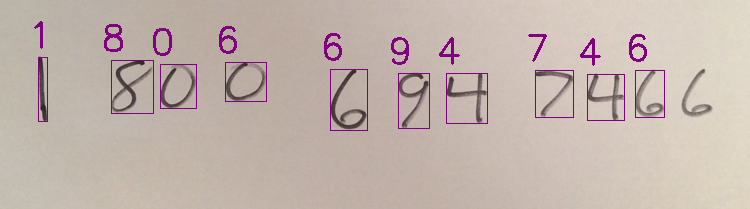

I think that number is: 6


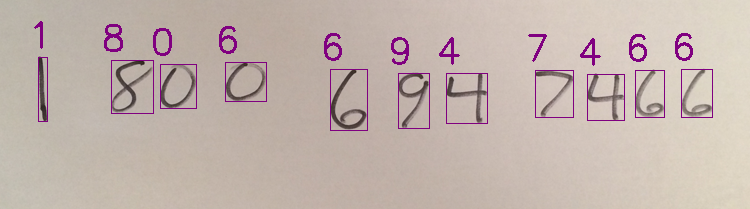

In [6]:
image = cv2.imread('apple_phonenumber.png')
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

blurred = cv2.GaussianBlur(gray, (5, 5), 0)
edged = cv2.Canny(blurred, 30, 150)
(contours, _) = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

contours = sorted([(c, cv2.boundingRect(c)[0]) for c in contours], key=lambda x: x[1])

for (c, _) in contours:
    (x, y, w, h) = cv2.boundingRect(c)

    if w >= 7 and h >= 20:
        roi = gray[y:y + h, x:x + w]
        thresh = roi.copy()
        T = mahotas.thresholding.otsu(roi)
        thresh[thresh > T] = 255
        thresh = cv2.bitwise_not(thresh)

        thresh = deskew(thresh, 20)
        thresh = center_extent(thresh, (20, 20))

        cv2_imshow(thresh)

        histogram = hog.describe(thresh)
        digit = model.predict([histogram])[0]
        print('I think that number is: {}'.format(digit))

        cv2.rectangle(image, (x, y), (x + w, y + h), (128, 0, 128), 1)
        cv2.putText(image, str(digit), (x - 10, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 1.2, (128, 0, 128), 2)
        cv2_imshow(image)
        cv2.waitKey(0)